# Running *GROMACS* on AQE for Polymer Melt Simulation

This notebook will demonstrate the pipeline to simulate a polymer melt or a mixture of polymers in a melt using GROMACS molecular dynamics software.\
A polymer melt refers to a state where a polymer is heated until it becomes a viscous, liquid-like fluid. This is often done to process the polymer into various shapes and forms through methods like injection molding or extrusion.\
A mixture of polymers in a melt means combining two or more different polymers while they are in this liquid state to create a new material with unique properties. This is similar to how metal alloys are made by mixing different metals.\
The pipeline will enable us to do the following:
- [x] Construction of _homopolymer_ with a user defined polymer chain length or molecular weight.
- [x] Construction of _homopolymer melt_ or _homopolymer mixture_.
- [x] Computation of various thermodynamic properties of the melt and polymeric properties.

A homopolymer is a polymer that is made up of only one type of monomer. Essentially, it consists of repeating units of the same molecule. For example, polyethylene is a homopolymer made entirely from ethylene monomers.
Construction of homopolymer means creating a polymer that consists of just one type of monomer, either with a specific chain length or molecular weight. This is in contrast to a copolymer, which would be made from two or more different monomers.

**The objective of this notebook is to enable user to compute:**
- [x] **The glass transition temperature (Tg) of the polymer/polymer mixture:** The glass transition temperature is a critical property in the study of polymers. It refers to the temperature range at which a polymer transitions from a hard, glassy material to a soft, rubbery state. Below the glass transition temperature, the polymer chains are in a rigid and brittle state, but above this temperature, they gain mobility and become more flexible and pliable.
- [x] **Cohesive energy density (CED) of polymer:** Cohesive energy density of a polymer is a measure of the energy required to separate the polymer molecules from each other to an infinite distance. It's essentially a way of quantifying the intermolecular forces within the polymer. In other words, CED gives an idea of how strongly the polymer molecules are attracted to each other. A higher cohesive energy density means the molecules are more strongly bound together, which can influence the material's properties like its solubility, mechanical strength, and glass transition temperature.
- [x] **Polymeric structural properties:** End-to-end distance distribution, radius of gyration and its eigen values.
- [x] **Diffusion coefficient of polymer:** The diffusion coefficient of a polymer is a measure of how quickly polymer molecules move or spread through a medium (like a solvent or another polymer). It indicates the rate at which individual polymer chains travel within the given material. It's important in various applications, such as in Material Science when studying the mobility of polymers and their response to environmental changes, or Polymer Processing when understanding how polymers mix and spread during manufacturing.

The major steps involved in the pipeline is as follows:
- **Step 1:** Load AiiDA profile.
- **Step 2:** User inputs for running the molecular dynamics simulation.
- **Step 3:** Import necessary python packages.
- **Step 4:** Polymer construction from the monomer.
- **Step 5:** Setup for molecular dynamics simulation.
- **Step 6:** Running the molecular dynamics simulation.
- **Step 7:** Calculation of primary properties.
- **Step 8:** Visualization of properties and polymer melt system.
- **Step 9:** Setup for molecular dynamics simulation for secondary properties calculation.
- **Step 10:** Running simulation for secondary properties calculation.
- **Step 11:** Calculation of secondary properties.

We will go through these aformentioned steps step by step.

<div class="alert alert-info">
 ℹ️ Currently the PoC is for linear homopolymer.
</div>

**Step 1:** Load AiiDA profile.\
We load an AiiDA profile. The `load_profile` method will load the default profile if no explicit profile name is specified.

In [1]:
from aiida import load_profile
load_profile()

Profile<uuid='e3eed8e7f41e49b094d7e9107f76a58a' name='gromacs'>

**Step 2:** User inputs for running the molecular dynamics simulation.\
We define a few **_user defined_** parameters which are used throughout the pipeline. The necessary parameters are classified in two group of parameters.\

- **_Parameters for polymer/monomer_**
1. **`monomer_pdbfilename`:** Name of the polymer for the MD simulation (**_NOTE: The dropdown for polymer selection will be given in the later version of the notebook._**)
2. **`monomer_count_per_polymer`:** Number of monomer units per polymer. (**_NOTE: There will be one alternate option of giving molecular weight of the polymer._**)
3. **`polymer_count`:** Number of polymer units for MD simulations. (**_NOTE: Add some note on the selection_**)

- **_Primary MD properties_**
1. **`primary_property_list`:** List of primary properties to be calculated from the MD simulation. (**_NOTE: Should use GROMACS notation_**)

- **_Parameters for MD simulations (Primary properties)_**
1. **`thermo_T`:** Simulation temperature in Kelvin (**_NOTE: This will be modified._**)
2. **`thermo_P`:** Simulation pressure in bar (**_NOTE: This will be modified._**)

- **_Secondary MD properties_**
1. **`secondary_property_list`:** List of secondary properties to be calculated from the MD simulation. (**_NOTE: Should use GROMACS notation_**)

- **_Parameters for MD simulations (Secondary properties)_**
1. **`thermo_T_range`:** Simulation temperature range is given for the secondary properties calculation. (**_NOTE: This will be modified._**)
2. **`thermo_T_increment`:** Simulation temperature increment is given for the secondary properties calculation (**_NOTE: This will be modified._**)

In [2]:
# Polymer/Monomer inputs
monomer_pdbfilename = '14tPBMonomer.pdb'        # PDB filename of the monomer
monomer_count_per_polymer = 4                   # Number of monomers present in one polymer

# Polymerization point
'''
4 elements in the list is given as follows:
    - element 1 and element 2 represent the last two atoms bonded where element 2 will be replace by next monomer element.
    - element 3 and element 4 represent the first two atoms bonded where element 3 will be replace by previous monomer element.
'''
polymer_last_bond_and_first_bond = ['CW', 'HW3', 'HA3', 'CA']
#['CW', 'HW3', 'HA3', 'CA'] -> 14tPBMonomer
#['CB', 'HB2', 'HA3', 'CA'] -> PVAMonomer

polymer_count = 600                             # Number of polymers will be simulated

# MD simulation outputs (primary properties)
primary_property_list = ['Potential', 'Density']

# MD simulation inputs
thermo_T = 300.15                               # Simulation Temperature (K)
thermo_P = 1.0                                  # Simulation Pressure (bar)

# MD simulation outputs (secondary properties)
secondary_property_list = ['Potential', 'Density'] #['Tg']

# MD simulation inputs
thermo_T_range = [290.15, 310.15]
thermo_T_increment = 5.0

**Step 3:** Import necessary python packages.

In [3]:
import pathlib
import os
import numpy as np

from aiida.engine import run, submit
from aiida.engine import calcfunction, WorkChain
from aiida.orm import Bool, Int, Float, Str, Dict, List, SinglefileData, FolderData, Computer
from aiida_shell import launch_shell_job

Convert the user input into `aiida.orm` data types accepted by the `node` arguments. 

In [4]:
monomer_pdbfilename = Str(monomer_pdbfilename)
monomer_count_per_polymer = Int(monomer_count_per_polymer)

polymer_last_bond_and_first_bond = List(polymer_last_bond_and_first_bond)
polymer_count = Int(polymer_count)

primary_properties = True
primary_property_list = List(primary_property_list)
thermo_T = Float(thermo_T)
thermo_P = Float(thermo_P)

secondary_properties = True
secondary_property_list = List(secondary_property_list)
if thermo_T_range[0] > thermo_T_range[1]:
    raise ValueError('Temperature range is not correct.')
thermo_T_list = List([thermo_T_range[0] + i * thermo_T_increment for i in range(0, int((thermo_T_range[1] - thermo_T_range[0])/thermo_T_increment)+1)])

**Step 4:** Polymer construction from the monomer.

The monomer pdb file is opened and wrapped it in AiiDA's `SinglefieData` data type, which allows it to be stored in the provenance graph.

In [5]:
monomer = SinglefileData(os.getcwd() + '/' + monomer_pdbfilename.value)

We use the PDB file containing the monomer structure and use a run(polymerize) workchain to automate the polymerization process. This workchain identifies the bonding sites in the monomer, iteratively connects them to form a polymer, and run till the number of monomer per chain is achieved. The output of this step is a dictionary containing the polymer's structural data wrapped in AiiDA's `SinglefileData` data type and atomic weight of the polymer chain. This streamlined approach eliminates the need for manual intervention.

In [6]:
from polymerize import PolymerizeWorkChain

polymer_data = run(PolymerizeWorkChain, monomer = monomer, monomer_count = monomer_count_per_polymer, last_bond_and_first_bond = polymer_last_bond_and_first_bond)

Polymerization starts for 14tPBMonomer.pdb ->
4


**Remove this once testing is completed**

In [7]:
'''
polymerfile = os.getcwd() + '/4mer-14tPB.pdb'
polymer_data = {
    'polymer': SinglefileData(polymerfile),
    'polymer_molecular_weight': Float(218.37764)
}
'''

"\npolymerfile = os.getcwd() + '/4mer-14tPB.pdb'\npolymer_data = {\n    'polymer': SinglefileData(polymerfile),\n    'polymer_molecular_weight': Float(218.37764)\n}\n"

##Visualization of Polymer Chain **(currently not working)**

In [8]:
import nglview as nv
import tempfile

def visualize(node: SinglefileData) -> nv.NGLWidget:
    with node.open(mode='rb') as source:
        with tempfile.NamedTemporaryFile(suffix=node.filename) as target:
            target.write(source.read())
            view = nv.NGLWidget()
            view.add_component(target.name)
            #view.clear_representations()
            view.add_ball_and_stick()
            return view

In [9]:
visualize(polymer_data['polymer'])

NGLWidget()

**Step 5:** Setup for molecular dynamics simulation.\
The initial step involves determining the simulation box length using the `calc_simulation_box_length` function. This calculation is based on the default polymer melt density of 0.40 g/cc and the specified number of polymer chains for the simulation. By leveraging this density, the function ensures that the simulation box is appropriately sized to represent the polymer melt environment accurately, maintaining realistic molecular interactions and spatial arrangements. This calculated box length serves as the foundation for subsequent simulation setup and execution.

In [10]:
import gromacs_setup

box_length = gromacs_setup.calc_simulation_box_length(polymer_data['polymer_molecular_weight'], polymer_count)

We configure the force-field folder and encapsulate it within AiiDA's `FolderData` data type, enabling its storage in the provenance graph. This folder contains the definitions for nonbonded and bonded interactions specific to the chosen force field, which will be utilized throughout the subsequent steps of the workflow.

In [11]:
# Default Parameters
ffdir = os.getcwd() + '/oplsaa.ff'
oplsaa = FolderData(tree=ffdir)

<div class="alert alert-info">
`gmx` is the GROMACS executable which will be executed with several parameters. The `nodes` argument takes a dictionary of `SinglefileData` and `FolderData` which will be copied to the working directory where the `gmx` command is executed. The `oplsaa` in `nodes` are copied to the `oplsaa.ff` folder in the working directory. If the key of the node appears as a placeholder in the `arguments` argument, it is replaced with its filename. 
</div>

`gmx pdb2gmx` is used to generate the forcefield information for the given polymer i.e.  nonbonded and bonded interaction parameters for all the atoms in the polymer

The `gmx pdb2gmx` is expected to generate three outputs of interest:
- `polymer_out.pdb`: `.pdb` file of the polymer.
- `topol.top`: The topology file.
- `posre.itp`: The position restraint file included in the topology file.

In [12]:
# Run `gmx pdb2gmx` to convert the PDB to GROMACS .gro format.
results_pdb2gmx, node_pdb2gmx = launch_shell_job(
    'gmx',
    arguments='pdb2gmx -f {polymer} -o polymer_out.pdb -water spce -ff oplsaa',
    nodes={
        'polymer': polymer_data['polymer'],
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['polymer_out.pdb', 'topol.top', 'posre.itp'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_pdb2gmx['stdout'].get_content())

<div class="alert alert-info">
These output files will be used in the upcoming steps in the pipeline. To capture these output files in the AiiDA's provenance graph, these filenames are declared in the `output` argunent. `aiida-shell` will wrap these output files in a `SinglefileDtata`.
</div>

Similar to the previous steps, GROMACS creates a simulation box where mutiple chains of the polymer will be inserted for the MD simulations. From the previous step, `.pdb` file of the single polymer chain is used to replicate the polymer chain inside the simulation box. In the output, we get a simulation box containing `polymer_count` number of polymers.

In [13]:
run = Bool(True)
while run.value:
    results_insert, node_insert = launch_shell_job(
        'gmx',
        arguments='insert-molecules -box {box_length} -ci {polymer} -nmol {polymer_count} -try 999 -o melt.pdb',
        nodes={
            'box_length': box_length,
            'polymer': polymer_data['polymer'],
            'polymer_count': polymer_count,
        },
        outputs=['melt.pdb'],
        metadata={'options': {'redirect_stderr': True}},
    )
    #print(results_insert['stdout'].get_content())
    run = gromacs_setup.check_insert_molecules(results_insert['stdout'], polymer_count)
    print(run.value)
    if run.value:
        
        run = Bool(False)
    else:
        run = Bool(False)
    print(run.value)

False
False


While running the `pdb2gmx` command we have created the topology for one single polymer chain. However, in the `topol.top` file we have to provide the number of polymer chain present in the simulation box. Therefore, we are updating the number of molecules line from 1 to `polymer_count` using the `sed` command.

In [14]:
results_updatetop, node_updatetop = launch_shell_job(
    'sed',
    arguments='-i "s/Other               1/Other               {polymer_count}/g" {top}',
    nodes={
        'polymer_count': polymer_count,
        'top': results_pdb2gmx['topol_top'],
    },
    outputs=['topol.top'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_updatetop['stdout'].get_content())

<div class="alert alert-info">
The output `topol.top` file is declared in the `output` argunent where `aiida-shell` will wrap these output files in a `SinglefileDtata`.
</div>

**Prerequisite for MD simulations and simulation box preparation is completed and we can proceed to run the molecular dynamics simulation.**

`gmx grompp` is used to generate a `.tpr` file written in binary format which has all the necessary input information for running the MD simulation.

The `gmx grompp` takes the input of three necesary files to generate the `.tpr` file.
- [x] `.mdp`: The molecular dynamics parameters.
- [x] `.gro`: The coordinate information of all the polymer chains present in the simulation box.
- [x] `.top`: The tolology file of the polymer. Also, this has the information of number of polymers present in the simulation box.

In [15]:
# Run `gmx grompp` to pre-process the parameters for energy minimization.
results_grompp_em, node_grompp_em = launch_shell_job(
    'gmx',
    arguments='grompp -f {mdp} -c {gro} -p {top} -o output.tpr',
    nodes={
        'mdp': gromacs_setup.get_em_mdp(),
        'gro': results_insert['melt_pdb'],
        'top': results_updatetop['topol_top'],
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['output.tpr'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_grompp_em['stdout'].get_content())

As we are proceeding towards the MD simulation, we must ensure that the simulations are running on the HPC to maximize the performance. Therefore, we are loading the AiiDA variable `Computer` where the information about the HPC will be given.

Now, the generated `.tpr` file is used for running the molecular dynamics simulation. We can run the `gmx mdrun` to run the energy minimization step. The variable `computer` is used in the `launch_shell_job` command ensures the use of HPC while running the simulation.

In [16]:
# Run `gmx mdrun` to run the energy minimization.
results_em, node_em = launch_shell_job(
    'gmx',
    arguments='mdrun -v -deffnm output -s {tpr}',
    nodes={
        'tpr': results_grompp_em['output_tpr'],
    },
    outputs=['output.edr', 'output.gro', 'output.log'],
    metadata={'call_link_label': 'pdb2gmx', 'options': {'redirect_stderr': True}},
    #metadata={'options': {'redirect_stderr': True, 'computer': computer, 'resources': 1
)
#print(results_em['stdout'].get_content())

Similar to the previous `gmx grompp` step, we can proceed with NPT equilibration step where the molecular dynamics simulation will be performed at the given thermodynamic conditions given by the user.

In [17]:
# Run `gmx grompp` to pre-process the parameters for energy minimization.
results_grompp_eqnpt, node_grompp_eqnpt = launch_shell_job(
    'gmx',
    arguments='grompp -f {mdp} -c {gro} -p {top} -o npt.tpr',
    nodes={
        'mdp': gromacs_setup.get_npt_mdp(thermo_T = thermo_T, thermo_P = thermo_P),
        'gro': results_em['output_gro'],
        'top': results_updatetop['topol_top'],
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['npt.tpr'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_grompp_eqnpt['stdout'].get_content())

/anfhome/software/anaconda/envs/aiida-gromacs/lib/python3.10/site-packages/aiida/engine/processes/ports.py:156: UserWarning: default of input port `id` is a `Node` instance, which can lead to unexpected side effects. It is advised to use a lambda instead, e.g.: `default=lambda: orm.Int(5)`.
  warnings.warn(UserWarning(message))
/anfhome/software/anaconda/envs/aiida-gromacs/lib/python3.10/site-packages/aiida/engine/processes/ports.py:156: UserWarning: default of input port `thermo_T` is a `Node` instance, which can lead to unexpected side effects. It is advised to use a lambda instead, e.g.: `default=lambda: orm.Int(5)`.
  warnings.warn(UserWarning(message))
/anfhome/software/anaconda/envs/aiida-gromacs/lib/python3.10/site-packages/aiida/engine/processes/ports.py:156: UserWarning: default of input port `thermo_P` is a `Node` instance, which can lead to unexpected side effects. It is advised to use a lambda instead, e.g.: `default=lambda: orm.Int(5)`.
  warnings.warn(UserWarning(message)

**Step 6:** Running the molecular dynamics simulation.
The generated `.tpr` file is used for running the molecular dynamics simulation for NPT equilibration. We can run the `gmx mdrun` to run the NPT equilibration step.

In [18]:
# Run `gmx mdrun` to run the equilibrium NPT simulations
results_eqnpt, node_eqnpt = launch_shell_job(
    'gmx',
    arguments='mdrun -v -deffnm output -s {tpr}',
    nodes={
        'tpr': results_grompp_eqnpt['npt_tpr'],
    },
    outputs=['output.edr', 'output.gro', 'output.log', 'output.xtc'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_eqnpt['stdout'].get_content())

**Step 7:** Calculation of primary primary properties. (e.g. - density, potential energy etc.)

<div class="alert alert-info">
Using `gmx energy` command we can calculate and plot the primary properties for the simulated polymer system.
</div>

<div class="alert alert-info">
The input for `gmx energy` is the `output.edr` from the `results_eqnpt`. Here we first pass `10` which corresponds to the potential energy, followed by `0` which finalizes the selection and completes the prompt. The `output` file of this step saved as GROMACS generated `.xvg` format.
</div>

In [19]:
primary_property_str = ''
for iproperty in primary_property_list.get_list():
    primary_property_str += iproperty + '\n'
primary_property_str += '0'

# Run `gmx energy` to extract the potential energy during the energy minimization.
results_energy, node_energy = launch_shell_job(
    'gmx',
    arguments='energy -f {edr} -o energy.xvg',
    nodes={
        'edr': results_eqnpt['output_edr'],
        'stdin': SinglefileData.from_string(primary_property_str),
    },
    outputs=['energy.xvg'],
    metadata={'options': {'redirect_stderr': True, 'filename_stdin': 'stdin'}},
)

**Step 8:** Visualization of properties and polymer melt system.
To visualize the data, first we need to import necessary python packages to be installed.

In [20]:
import io

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, IFrame

In [21]:
#results_energy['energy_xvg'].get_content().split('\n')

We define the `create_plot` function and pass the `potential.xvg` from the previous step. The `create_plot` will create a plot which is saved to a stream in memory which is then passed to a `SinglefileData` node to store it in AiiDA's provecance graph.

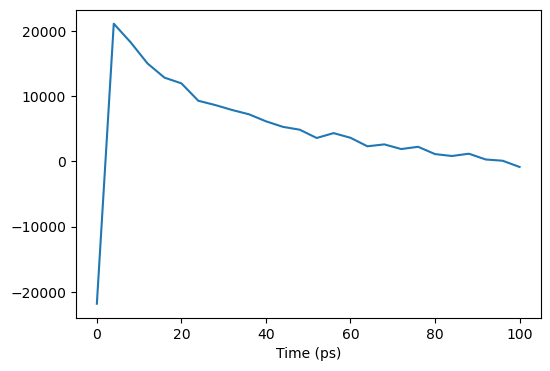

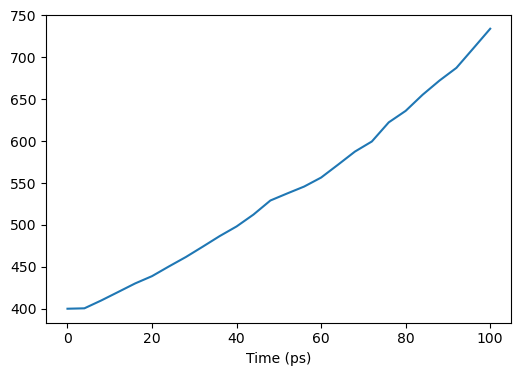

In [22]:
#@calcfunction
def create_plot(xvg: SinglefileData) -> dict:
    """Plot the data of a XVG output file."""
    lines = xvg.get_content().split('\n')
    data = np.loadtxt(lines, comments=['#', '@']).T
    
    #comment = [line for line in lines if line.startswith('@')]

    plot = {}
    for iplot in range(len(data)-1):
        plt.figure(figsize=(6,4))
        plt.plot(data[0], data[iplot+1])
        stream = io.BytesIO()
        plt.xlabel('Time (ps)')
        #plt.ylabel('Potential energy [kJ/mol]')
        plt.savefig(stream, format='png', bbox_inches='tight', dpi=150)
        plot[f'{iplot}'] = SinglefileData(stream, filename=f'plot-{iplot}.png')
    return plot
    
# Create a plot from the extracted potential energy of the system
plot = create_plot(results_energy['energy_xvg'])

**Step 9:** Setup for molecular dynamics simulation for secondary properties calculation.

We are going to perform multiple molecular dynamics simulation by varying temperatures or varying pressure or varying both temperature and pressure. This variation in temeprature and pressure is controlled based on the user input.

As the varying parameters are temperature and pressure, we do not need to perform the complete gromacs setup as we performed previously. We are executing the GROMACS `grompp` command to generate `.tpr` file for all the thermodynamics conditions (i.e. - temperature range or pressure range or both.) These `.tpr` files will be used to run the molecular dynamics simulations. 

<div class="alert alert-info">
A `AiiDA's` list of `AiiDA node` instances are created for temperature and pressure range. These `node` instances will be called in the later step to run the molecular dynamics simulations.
</div>

In [23]:
node_grompplist = List([])
results_grompplist = List([])

for i, thermo_T_i in enumerate(thermo_T_list.get_list()):
    id = Int(i)
    thermo_T_curr = Float(thermo_T_i)
    eqnpt_mdp = gromacs_setup.get_npt_mdp(id, thermo_T_curr, thermo_P)
    #print(eqnpt_mdp.filename)
    
    tpr = f'npt-{i}.tpr'
    results_grompp_eqnpt, node_grompp_eqnpt = launch_shell_job(
        'gmx',
        arguments='grompp -f {mdp} -c {gro} -p {top} -o {tpr}',
        nodes={
            'mdp': eqnpt_mdp,
            'gro': results_em['output_gro'],
            'top': results_updatetop['topol_top'],
            'tpr': Str(tpr),
            'folder': oplsaa,
        },
        filenames={
            'folder': 'oplsaa.ff'
        },
        outputs=[tpr],
        metadata={'options': {'redirect_stderr': True}},
    )
    node_grompplist.append(node_grompp_eqnpt)
    results_grompplist.append(results_grompp_eqnpt)

**Step 10:** Running simulation for secondary properties calculation.

The series of molecular dynamics simulation is running. A `list` of ouput will be generated for different thermodynamic conditions.

**Job submission is not working currently**

In [ ]:
# Run `gmx mdrun` to run the equilibrium NPT simulations at different T & P
node_eqnptlist = List([])
results_eqnptlist = List([])

for i, thermo_T_ele in enumerate(thermo_T_list.get_list()):
    #print(i, thermo_T_ele, type(thermo_T_ele), type(i))
    tpr = f'npt_{i}_tpr'
    output = f'npt-{i}'
    results_eqnpt, node_eqnpt = launch_shell_job(
        'gmx',
        arguments='mdrun -v -deffnm {output} -s {tpr}',
        nodes={
            'tpr': results_grompplist[i][tpr],
            'output': Str(output),
        },
        outputs=[f'{output}.edr', f'{output}.gro', f'{output}.log', f'{output}.xtc'],
        metadata={'options': {'redirect_stderr': True}},
    )
    node_eqnptlist.append(node_eqnpt)
    results_eqnptlist.append(results_eqnpt)

**Step 11:** Calculation of secondary properties.

Secondary properties for this system at all the thermodynamic condtions are getting calculated.

In [ ]:
secondary_property_str = ''
for iproperty in secondary_property_list.get_list():
    secondary_property_str += iproperty + '\n'
secondary_property_str += '0'

node_energylist = List([])
results_energylist = List([])

for i, thermo_T_ele in enumerate(thermo_T_list.get_list()):
    edr = f'npt_{i}_edr'
    output = f'energy-{i}.xvg'
    results_energy, node_energy = launch_shell_job(
        'gmx',
        arguments='energy -f {edr} -o {output}',
        nodes={
            'edr': results_eqnptlist[i][edr],
            'output': Str(output),
            'stdin': SinglefileData.from_string(secondary_property_str),
        },
        outputs=[f'{output}'],
        metadata={'options': {'redirect_stderr': True, 'filename_stdin': 'stdin'}},
    )
    node_energylist.append(node_energy)
    results_energylist.append(results_energy)

In [ ]:
#results_energylist.get_list()[0]['energy_0_xvg'].get_content().split('\n')
plot = {}
for iproperty in secondary_property_list.get_list():
    iproplist = []
    for i, thermo_T_ele in enumerate(thermo_T_list.get_list()):
        line = [line for line in results_energylist.get_list()[i]['stdout'].get_content().split('\n') if line.startswith(iproperty)]
        if len(line) > 1:
            raise ValueError('Multiple entry detected.')
        iproplist.append(line[0].split()[1])

    plt.figure(figsize=(6,4))
    plt.plot(thermo_T_list.get_list(), iproplist)
    stream = io.BytesIO()
    plt.xlabel('Temperature (K)')
    plt.ylabel('')
    plt.savefig(stream, format='png', bbox_inches='tight', dpi=150)
    plot[f't-{iproperty}'] = SinglefileData(stream, filename=f'plot-t-{iproperty}.png')
    
    del iproplist